In [29]:
#%pip install transformers
#!pip install pandas
#%pip install torch

import pandas as pd
import os
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
import re
import matplotlib.pyplot as plt

In [30]:
print(f"PyTorch version: {torch.__version__}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 1.13.0
Using device: mps


Model 1: https://huggingface.co/roberta-base
Model 2: https://huggingface.co/vinai/bertweet-base

In [31]:
class IntrasentenceEvaluator():
    
    def __init__(self, data, choices, model):
        self.data = data
        self.choices = choices
        self.model_name = model
        self.process_sentences()
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.sent_encodings, self.word_encodings, self.mask_idxs = self.make_encodings() #store the encodings
        self.model = AutoModelForMaskedLM.from_pretrained(model)
        
    #Function to make predictions and calculate how often the biased words are chosen
    def run_model_and_evaluate(self):
        output = self.make_predictions()
        # self.bias = self.get_bias(output) #how often do we get the bias
        # self.saveDecisions(output)
        self.get_bias(output)

    #Insert the candidates words inside the sentences
    def process_sentences(self,s='______'):
        candidate_sentence = []
        for index,row in self.data.iterrows():
            candidate_sentence.append([re.sub(s,row.loc[c], row.loc['sentence']) for c in self.choices.keys()]) #replace s with candidate words
        self.data.loc[:,'candidate_sentence'] = candidate_sentence
    
    #find the mask indices for the encoded sentence.
    def get_sublist_idxs_in_list(self, word, sentence):
        possibles = np.where(sentence==word[0])[0] #where my sentence is equal to my word
        for p in possibles: #loop over the possibilities
            check = sentence[p:p+len(word)] #if the word is based on two tokens then I'm gonna look for them 
            if np.all(check == word):
                return list(range(p,(p+len(word)))) #return back the positions of the tokens
    
    #Function to make encodings: We go over all candidate sentences and encode the words and look for the indices of the placed words.
    def make_encodings(self): 
        sent_encoding = [] #tokenized sentenced
        word_encoding = [] #tokenized words
        mask_idxs = [] #the indexes where the tokens of the choices are, i.e. where the <mask> should be into the candidates sentences
        for index,row in self.data.iterrows():
            _sent_encoding,_word_encoding,_mask_idxs=[],[],[] #sublists, we have 3 for each sentences
            for i,(word,sentence) in enumerate(zip(row[self.choices.keys()],row.loc['candidate_sentence'])): #for each sentences we creted in the previous function
                encoded_word = self.tokenizer.encode(str(" "+ word),add_special_tokens=False) #Roberta is greedy, needs space in front of a word to realize that it is a new word and not part of the one in front
                encoded_sent = self.tokenizer.encode_plus(sentence, add_special_tokens = True, return_tensors = 'pt', padding='max_length', max_length=128, return_attention_mask=True)
                tokens_to_mask_idx = self.get_sublist_idxs_in_list(np.array(encoded_word),np.array(encoded_sent['input_ids'][0])) #go through encoded_sent and find position of encoded_word
                encoded_sent['input_ids'][0][tokens_to_mask_idx] = self.tokenizer.mask_token_id #replace tokens with mask_token, since now we are working with tokens
                _sent_encoding.append(encoded_sent)
                _word_encoding.append(encoded_word)
                _mask_idxs.append(tokens_to_mask_idx)
            sent_encoding.append(_sent_encoding)
            word_encoding.append(_word_encoding)
            mask_idxs.append(_mask_idxs)
        return sent_encoding , word_encoding , mask_idxs
    
    #Function to make predictions:
    # We go over all sentences with help of the made encoding and see which placed words in the candidate sentences return the highest probability of being chosen.
    # We also see which words the mask filler, i.e. our model, would choose itself for the masked token.
    def make_predictions(self):
        output = [] #we want what option with highest probability has been chosen
        for q_idx, (w, s, m) in enumerate(zip(self.word_encodings, self.sent_encodings, self.mask_idxs)):
            predictions =[]
            candidate_input_ids = torch.stack([inp_ids['input_ids'].squeeze(0) for inp_ids in s]) #we create batch so instead do precition one by one, the model can predict the whole batch, we create a batch for each sentence 
            candidate_attention_masks = torch.stack([am['attention_mask'].squeeze(0) for am in s])
            candidate_logits = self.model(candidate_input_ids, attention_mask=candidate_attention_masks).logits #where logits is  raw output of the model -> prediction
            # -> output shape: 3 * num of tokens*vocab size, e.g. a prediction over the vocabulary for each token in each candidate question
            # -> probability distribution over the whole vocab size
            #print(candidate_logits)
            for idx, (token, mask_idxs) in enumerate(zip(w, m)): #for each of the 3 candidate sentences, we need to pick out the token that we masked in the sentence
                mask_token_logits = candidate_logits[idx, mask_idxs, token] # here we want to find the raw prediction for the candidate word
                candidate_score = float(torch.mean(mask_token_logits)) #if we have more than one mask this is our "pseudo accuracy"
                #print(candidate_score)
                predictions.append(candidate_score)
            #print(f"iprediction: {q_idx}, values: {predictions}")
            output.append(np.argmax(predictions) + 1) #start the keys for the choices at 1 as well > returns the choice that is chosen as an answer, we don't need that
        #print(output)
        return output
    
    #Function to see how often the biased words were chosen.
    def get_bias(self,predictions):
        biased, unbiased, unrelated = 0, 0, 0
        for pred in predictions:
            if pred == 1:
                biased +=1
            if pred == 2:
                unbiased += 1
            if pred == 3:
                unrelated += 1
        print(f"biased: {biased}")
        print(f"unbiased: {unbiased}")
        print(f"unrelated: {unrelated}")
        self.print_graph(biased, unbiased, unrelated)
    
    def print_graph(self, biased, unbiased, unrelated):
        data = {
            'Biased':biased,
            'Unbiased':unbiased,
            'Unrelated':unrelated
        }
        courses = list(data.keys())
        values = list(data.values())
        
        fig = plt.figure(figsize = (10, 5))
        
        # creating the bar plot
        plt.bar(courses, values, color ='maroon',
                width = 0.4)
        
        plt.xlabel("Choices")
        plt.ylabel("Number of sentence")
        plt.title(f"Intrasentence test - {self.model_name}")
        plt.show()
        

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


biased: 11
unbiased: 8
unrelated: 0


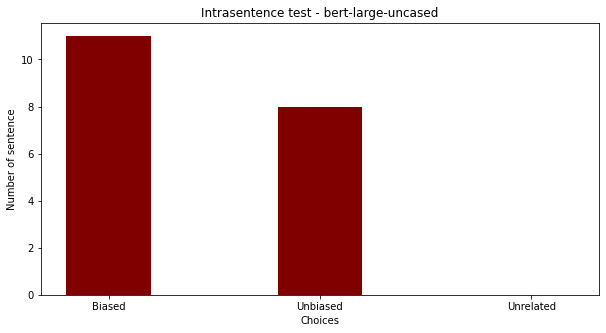

In [32]:
choices = {'bias':1, 'unbiased':2,'unrelated':3} 
file_path = 'dataset/testing_data_intra.csv' #"drive/MyDrive/Final_templates.csv"#"drive/MyDrive/New_templates.csv"
model_name = 'bert-large-uncased'
templates = pd.read_csv(file_path, sep=";")
evaluator = IntrasentenceEvaluator(templates.copy(), choices, model_name)
evaluator.run_model_and_evaluate()